In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

C:\Users\succa\AppData\Local\Temp\ipykernel_8488\2354669594.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from math import log2
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats import inter_rater as irr
from statsmodels.tsa.stattools import adfuller
import pingouin as pg
pd.options.mode.chained_assignment = None

C:\Users\succa\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\succa\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

In [4]:
def get_Fame(arr):
    first_entry = np.where(arr != 0)[0][0]
    return np.median(arr[first_entry:])

In [6]:
Mass_shooting_df = pd.read_excel("Mass_Shootings_dummy.xlsx", sheet_name = "Mass_Shootings")
Mass_shooting_df = Mass_shooting_df.drop_duplicates(subset=['Date'])
Mass_shooting_df = Mass_shooting_df.reset_index()
N = len(Mass_shooting_df)
Variables = ["Target_Group"]
wo = np.zeros([N,N])
for i in range(N):
    for j in range(i):
        wo[i,j] = 1
for Variable in Variables:
    Mass_shooting_df = Mass_shooting_df.reindex(columns = Mass_shooting_df.columns.tolist() + [Variable+"_Surprisal"])

In [8]:
Wikipedia_df = pd.read_excel("Mass_Shootings_dummy.xlsx", sheet_name = "Wikiepdia")
for col in Wikipedia_df.columns:
    if col != "DateTime":
        Wikipedia_df[col] = pd.to_numeric(Wikipedia_df[col])
Wikipedia_df["DateTime"] = pd.to_datetime(Wikipedia_df["DateTime"])

In [9]:
Mass_shooting_df["Fame"] = np.zeros([len(Mass_shooting_df)])

for i in range(len(Mass_shooting_df)):
    if (Mass_shooting_df["WikiPage_reference"][i]=="There's a wikipedia page but not on the data site") | (Mass_shooting_df["WikiPage_reference"][i]=="No_page") | (Mass_shooting_df["WikiPage_reference"][i]=="Corrupted"): 
        Mass_shooting_df["Fame"][i] = np.nan
    else:
        fame_score = get_Fame(Wikipedia_df[Mass_shooting_df["WikiPage_reference"][i]].values)
        Mass_shooting_df["Fame"][i] = fame_score

In [10]:
target_df = pd.read_excel("Mass_Shootings_dummy.xlsx", sheet_name = "Alpha&Kappa_TargetGroup")

In [11]:
target_df["index"] = target_df["subject"]
for i in range(len(target_df)):
    target_df["index"].iloc[i] = int(target_df["subject"][i][1:])
target_df = target_df.set_index('index')

In [12]:
Man_U_test_Pval = []
Corr_rho = []
Corr_Pval = []
for whatever in range(20):
    for i in range(len(Mass_shooting_df)):
        targets = np.array(target_df.loc[Mass_shooting_df["Case"].iloc[i]][1:6])
        Tar_uniques, Tar_counts = np.unique(targets, return_counts = True)
        if len(Tar_counts)==2:
            if np.all(Tar_counts==[3,2]) or np.all(Tar_counts==[2,3]):
                Mass_shooting_df["Target_Group"].iloc[i] = np.random.choice(Tar_uniques, 1, p=[Tar_counts[0]/5,Tar_counts[1]/5])[0]
        else:
            maxx = np.max(Tar_counts)
            max_indecies = np.where(Tar_counts==maxx)[0]
            choices = Tar_uniques[max_indecies]
            Mass_shooting_df["Target_Group"].iloc[i] = np.random.choice(choices, 1, p=(1/len(choices))*np.ones([len(choices)]))[0]
    for index , Variable in enumerate(Variables):
        uniques = np.unique(Mass_shooting_df[Variable])
        L = len(uniques)
        C = np.zeros([N, int(L)])
        J = np.ones([N, int(L)])
        for i in range(N):
            for j in range(len(uniques)):
                C[i, j] = 1 if (Mass_shooting_df[Variable][i] == uniques[j]) else 0
        priorDis = np.dot(wo,C)
        choices = np.argwhere(C==1)[:,1]
        for i in range(1,N):
            history = priorDis[i,:]
            choice = priorDis[i,choices[i]]
            y = -log2((choice+1)/(L+np.sum(history)))
            Mass_shooting_df[Variable+"_Surprisal"][i] = y
    
    RandomMass_shooting_df = Mass_shooting_df.iloc[1:]
    RandomMass_shooting_df = RandomMass_shooting_df.reset_index()
    
    fs = np.array(RandomMass_shooting_df.loc[RandomMass_shooting_df["FameSeeker_Silva"]]["Target_Group"+"_Surprisal"])
    nfs = np.array(RandomMass_shooting_df.loc[RandomMass_shooting_df["FameSeeker_Silva"]==False]["Target_Group"+"_Surprisal"])
    U_pval = mannwhitneyu(nfs, fs, alternative='less',method='auto')[1]
    Man_U_test_Pval.append(U_pval)
    
    Correlation_df = RandomMass_shooting_df.dropna(subset=['Fame'])[["Fame","Injured","Fatalities","Target_Group_Surprisal"]]
    
    Corr = pg.partial_corr(data=Correlation_df, x='Fame', y='Target_Group_Surprisal', covar=['Fatalities','Injured'],method = "spearman").round(4)
    
    Corr_rho.append(Corr['r'][0])
    Corr_Pval.append(Corr["p-val"][0])
Output = pd.DataFrame({"Man_U_test_Pval":Man_U_test_Pval,"Corr_Pval":Corr_Pval,"Corr_rho":Corr_rho})
Output.to_csv("Data/Monte_carlo_3V2&2V2.csv")

KeyError: 'Case'

In [ ]:
plt.hist(Man_U_test_Pval, bins = 100);
#plt.axvline(x = 0.05)
#plt.yscale('log')

# plt.axvline(x = 0.025)
plt.title("U_test");

In [14]:
print(np.sum(np.array(Man_U_test_Pval) <0.05))
print(np.sum(np.array(Corr_Pval) <0.05))

20000
19754


In [15]:
print(np.sum(np.array(Man_U_test_Pval) <0.025))
print(np.sum(np.array(Corr_Pval) <0.025))

20000
18955


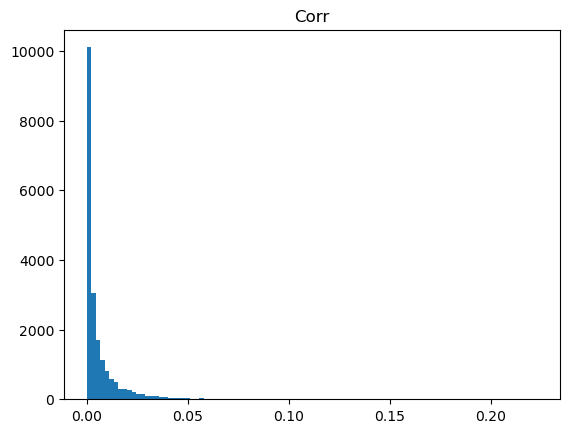

In [27]:
plt.hist(Corr_Pval,bins = 100);
#plt.yscale('log')
# plt.axvline(x = 0.05)
# plt.axvline(x = 0.025)
plt.title("Corr");

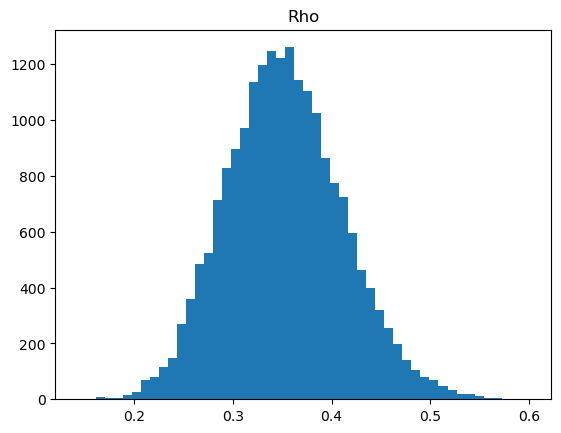

In [17]:
plt.hist(Corr_rho,bins = 50);
plt.title("Rho");